In [1]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


In [2]:
#!pip install datasets


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("go_emotions")
df = dataset["train"].to_pandas()
df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,[18],edsb738
43406,Always thought that was funny but is it a refe...,[6],ee7fdou
43407,What are you talking about? Anything bad that ...,[3],efgbhks
43408,"More like a baptism, with sexy results!",[13],ed1naf8


In [5]:
# Define priority-based emotion mapping
emotion_map = {
    "positive": {"admiration", "relief", "love", "approval", "optimism", "pride", "gratitude",
                 "caring", "joy", "excitement", "amusement", "desire"},

    "neutral": {"neutral", "curiosity", "surprise", "realization", "confusion"},

    "bad": {"disgust", "disapproval", "disappointment", "anger", "nervousness",
            "fear", "annoyance", "embarrassment"},

    "verybad": {"grief", "sadness", "remorse"}
}

# Function to classify into 4 categories based on highest priority
def map_to_category(emotions):
    for category, emotion_set in emotion_map.items():
        if any(emotion in emotion_set for emotion in emotions):
            return category
    return "neutral"  # Default to neutral if no matching category found


In [6]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("go_emotions")

# Get list of emotion label names
label_names = dataset["train"].features["labels"].feature.names
df = dataset["train"].to_pandas()

# Map label indices to emotion names
df["emotion"] = df["labels"].apply(lambda x: [label_names[i] for i in x])
df["emotion_category"] = df["emotion"].apply(map_to_category)
category_counts = df["emotion_category"].value_counts()
print(category_counts.to_dict())


{'neutral': 17867, 'positive': 17410, 'bad': 6856, 'verybad': 1277}


In [7]:
import random
from nltk.corpus import wordnet

def synonym_replacement(text, n=2):
    words = text.split()
    if len(words) < n:
        n = len(words)

    new_words = words.copy()
    random_idx = random.sample(range(len(words)), n) if n > 0 else []

    for idx in random_idx:
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            new_words[idx] = synonyms[0].lemmas()[0].name()  # Replace with synonym

    return " ".join(new_words)

# Apply augmentation only for "bad" and "verybad" categories
df_augmented = df[df["emotion_category"].isin(["bad", "verybad"])].copy()
df_augmented["text"] = df_augmented["text"].apply(lambda x: synonym_replacement(x))

# Append the augmented data to the original dataset
df = pd.concat([df, df_augmented])
df

,text,labels,id,emotion,emotion_category
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],neutral
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],neutral
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],bad
3,To make her feel threatened,[14],ed7ypvh,[fear],bad
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],bad
...,...,...,...,...,...
43384,My inevitable famine is when I run out of pop ...,[25],edt2a5d,[sadness],verybad
43388,Fuck these trendy hipster joints. Give Maine m...,"[2, 3]",ee3nyiy,"[anger, annoyance]",bad
43394,It is. I bet chantex and all the other 'quit s...,[10],ed6chs0,[disapproval],bad
43400,[NAME] Washington half-blood but it wasn't a s...,[10],eerlirr,[disapproval],bad


In [8]:
df

,text,labels,id,emotion,emotion_category
0,My favourite food is anything I didn't have to...,[27],eebbqej,[neutral],neutral
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,[neutral],neutral
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,[anger],bad
3,To make her feel threatened,[14],ed7ypvh,[fear],bad
4,Dirty Southern Wankers,[3],ed0bdzj,[annoyance],bad
...,...,...,...,...,...
43384,My inevitable famine is when I run out of pop ...,[25],edt2a5d,[sadness],verybad
43388,Fuck these trendy hipster joints. Give Maine m...,"[2, 3]",ee3nyiy,"[anger, annoyance]",bad
43394,It is. I bet chantex and all the other 'quit s...,[10],ed6chs0,[disapproval],bad
43400,[NAME] Washington half-blood but it wasn't a s...,[10],eerlirr,[disapproval],bad


In [9]:
import random
from nltk.corpus import wordnet

def synonym_replacement(text, n=2):
    words = text.split()
    if len(words) < n:
        n = len(words)

    new_words = words.copy()
    random_idx = random.sample(range(len(words)), n) if n > 0 else []

    for idx in random_idx:
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            new_words[idx] = synonyms[0].lemmas()[0].name()  # Replace with synonym

    return " ".join(new_words)

# Select only "verybad" samples for augmentation
df_verybad = df[df["emotion_category"] == "verybad"].copy()

# Apply synonym replacement multiple times to increase "verybad" data
num_augmentations = 3  # Adjust this to balance the dataset
df_augmented_list = []

for _ in range(num_augmentations):
    df_temp = df_verybad.copy()
    df_temp["text"] = df_temp["text"].apply(lambda x: synonym_replacement(x))
    df_augmented_list.append(df_temp)
df_augmented = pd.concat(df_augmented_list)
df = pd.concat([df, df_augmented])

# Shuffle dataset
df = df.sample(frac=1).reset_index(drop=True)

print(df["emotion_category"].value_counts())  # Check category distribution


emotion_category
neutral     17867
positive    17410
bad         13712
verybad     10216
Name: count, dtype: int64


In [10]:
print(df["emotion_category"].value_counts())  # Check category distribution

emotion_category
neutral     17867
positive    17410
bad         13712
verybad     10216
Name: count, dtype: int64


In [11]:
df.dropna(inplace=True)

In [12]:
X = df['text'].values
y = df['emotion_category'].values
y

array(['positive', 'neutral', 'verybad', ..., 'neutral', 'neutral', 'bad'],
      dtype=object)

In [13]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

In [14]:
print(set(y))

{0, 1, 2, 3}


In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len)


In [17]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    GRU(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
# Train the RNN model
history = model.fit(
    X_train_seq, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_seq, y_test),
    verbose=1
)


Epoch 1/5
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 153s 101ms/step - accuracy: 0.5314 - loss: 1.0266 - val_accuracy: 0.7290 - val_loss: 0.6683
Epoch 2/5
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 199s 99ms/step - accuracy: 0.7661 - loss: 0.5978 - val_accuracy: 0.7476 - val_loss: 0.6181
Epoch 3/5
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 196s 95ms/step - accuracy: 0.7991 - loss: 0.5132 - val_accuracy: 0.7538 - val_loss: 0.6123
Epoch 4/5
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 143s 97ms/step - accuracy: 0.8245 - loss: 0.4556 - val_accuracy: 0.7566 - val_loss: 0.6171
Epoch 5/5
1481/1481 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - accuracy: 0.8496 - loss: 0.3973 - val_accuracy: 0.7595 - val_loss: 0.6198


In [20]:
y_pred = np.argmax(model.predict(X_test_seq), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

371/371 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Final Accuracy: 0.76
              precision    recall  f1-score   support

         bad       0.75      0.70      0.73      2790
     neutral       0.64      0.70      0.67      3493
    positive       0.79      0.74      0.77      3503
     verybad       0.92      0.97      0.94      2055

    accuracy                           0.76     11841
   macro avg       0.78      0.78      0.78     11841
weighted avg       0.76      0.76      0.76     11841



In [21]:
# model.save("rnn_emotion_classifier.h5")
# joblib.dump(tokenizer, "tokenizer.pkl")
# joblib.dump(label_encoder, "label_encoder.pkl")
# print("Model, tokenizer, and label encoder saved successfully.")

In [22]:

df_test = dataset["test"].to_pandas()

df_test["emotion"] = df_test["labels"].apply(lambda x: ", ".join([label_names[i] for i in x]))

# Function to assign only ONE category per sample
def map_to_category(emotions):
    emotion_list = emotions.split(", ")
    for e in ["grief", "sadness", "remorse"]:  # Very Bad First
        if e in emotion_list:
            return "verybad"
    for e in ["disgust", "disapproval", "disappointment", "anger", "nervousness", "fear", "annoyance", "embarrassment"]:  # Bad Second
        if e in emotion_list:
            return "bad"
    for e in ["neutral", "curiosity", "surprise", "realization", "confusion"]:  # Neutral Third
        if e in emotion_list:
            return "neutral"
    return "positive"  # Otherwise, assume positive

# Apply mapping function
df_test["emotion_category"] = df_test["emotion"].apply(map_to_category)

# Drop missing values
df_test.dropna(inplace=True)

# Prepare test data
X_test = df_test["text"].values
y_test = df_test["emotion_category"].values

# Ensure test labels exist in encoder
y_test = label_encoder.transform(y_test)

# Tokenize and pad test sequences
max_len = 100  # Same as training
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Predict
y_pred = np.argmax(model.predict(X_test_seq), axis=1)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Final Test Accuracy: 0.67
              precision    recall  f1-score   support

         bad       0.58      0.49      0.53      1050
     neutral       0.68      0.71      0.69      2302
    positive       0.72      0.76      0.74      1863
     verybad       0.55      0.50      0.52       212

    accuracy                           0.67      5427
   macro avg       0.63      0.61      0.62      5427
weighted avg       0.67      0.67      0.67      5427



In [23]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Final Test Accuracy: 0.67
              precision    recall  f1-score   support

         bad       0.58      0.49      0.53      1050
     neutral       0.68      0.71      0.69      2302
    positive       0.72      0.76      0.74      1863
     verybad       0.55      0.50      0.52       212

    accuracy                           0.67      5427
   macro avg       0.63      0.61      0.62      5427
weighted avg       0.67      0.67      0.67      5427



In [24]:
import matplotlib.pyplot as plt

# Replace this with your actual training history
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


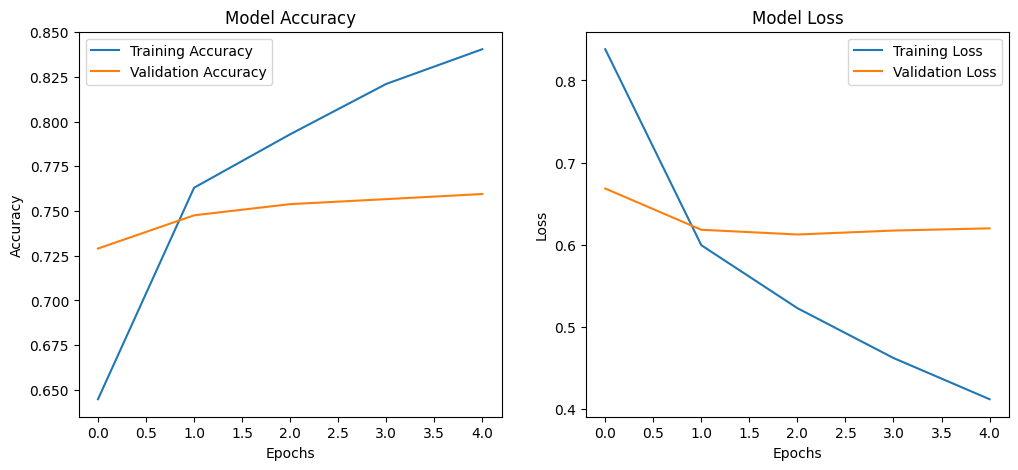

In [25]:
history_dict = history.history

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()
